In [1]:
import fs
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from joblib import dump
from joblib import load
from sklearn.model_selection import cross_val_score

import optuna
from sklearn.model_selection import StratifiedKFold

In [2]:
PROCESSED_PROJECT_DIR = fs.open_fs("../../data/processed/project")
TRAIN_DIR = PROCESSED_PROJECT_DIR.getsyspath("train.csv")
TEST_DIR = PROCESSED_PROJECT_DIR.getsyspath("test.csv")
VAL_DIR = PROCESSED_PROJECT_DIR.getsyspath("validation.csv")

MODEL_PROJECT_DIR = fs.open_fs("../../models/project")
TUNING_FILE_NAME = MODEL_PROJECT_DIR.getsyspath("pipeline_model_tuning.joblib")

In [3]:
train_df = pd.read_csv(TRAIN_DIR)
val_df = pd.read_csv(VAL_DIR)
test_df = pd.read_csv(TEST_DIR)


categoric_features = ['BAD', 'REASON', 'JOB']
train_df[categoric_features] = train_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

categoric_features = ['BAD', 'REASON', 'JOB']
val_df[categoric_features] = val_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = val_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

categoric_features = ['BAD', 'REASON', 'JOB']
test_df[categoric_features] = test_df[categoric_features].apply(lambda col: col.astype('category'))
numeric_features = test_df.select_dtypes(include=['int', 'float']).columns.tolist()
categoric_features = ['REASON', 'JOB']

X_val = val_df.drop(columns=['BAD'])
y_val = val_df['BAD']

X_train = train_df.drop(columns=['BAD'])
y_train = train_df['BAD']

X_test = test_df.drop(columns=['BAD'])
y_test = test_df['BAD']

In [4]:
def objective(trial):
    # Hiperparámetros que Optuna va a ajustar
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  # Métrica de evaluación
        'n_estimators': trial.suggest_int('n_estimators', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

    preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

    # Crear el modelo XGBoost
    model = XGBClassifier(**param)

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

    # Usamos validación cruzada con StratifiedKFold
    skf = StratifiedKFold(n_splits=3)
    
    # Evaluamos el modelo con validación cruzada
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')

    # Devolver la precisión promedio de la validación cruzada
    return scores.mean()

In [5]:
# Crear el estudio Optuna y optimizar
study = optuna.create_study(direction='maximize')  # Queremos maximizar la recall
study.optimize(objective, n_trials=50)  # Probará 50 combinaciones de hiperparámetros

[I 2024-09-24 23:57:29,078] A new study created in memory with name: no-name-9de0dd6e-6d02-4e09-9ffe-720c2409dabd
[I 2024-09-24 23:57:29,127] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 4, 'learning_rate': 0.08417697167183939, 'max_depth': 5}. Best is trial 0 with value: 0.0.
[I 2024-09-24 23:57:29,179] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 3, 'learning_rate': 0.021290520792626867, 'max_depth': 9}. Best is trial 0 with value: 0.0.
[I 2024-09-24 23:57:29,218] Trial 2 finished with value: 0.24319727891156462 and parameters: {'n_estimators': 5, 'learning_rate': 0.17980104190237953, 'max_depth': 4}. Best is trial 2 with value: 0.24319727891156462.
[I 2024-09-24 23:57:29,271] Trial 3 finished with value: 0.4931972789115646 and parameters: {'n_estimators': 6, 'learning_rate': 0.22478943222848427, 'max_depth': 8}. Best is trial 3 with value: 0.4931972789115646.
[I 2024-09-24 23:57:29,323] Trial 4 finished with value: 0.5391156462585035 and par

In [6]:
# Mostrar los mejores hiperparámetros encontrados
print("Mejores Hiperparámetros:", study.best_params)

Mejores Hiperparámetros: {'n_estimators': 8, 'learning_rate': 0.279245240898263, 'max_depth': 10}


In [7]:
# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
model = XGBClassifier(**best_params)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OrdinalEncoder(), categoric_features)
    ])

pipeline_tuning = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

In [9]:
model_tuning = pipeline_tuning.fit(X_train, y_train)

In [10]:
dump(pipeline_tuning, TUNING_FILE_NAME)

['/Users/miguelsepulveda/Library/CloudStorage/OneDrive-Personal/MacBook/UP/MCD/Materias/ML II/MCD-ML2/models/project/pipeline_model_tuning.joblib']

In [11]:
model_tuning = load(TUNING_FILE_NAME)

In [12]:
# Predecir y evaluar el modelo en el conjunto de prueba
y_pred = model_tuning.predict(X_val)
recall = metrics.recall_score(y_val, y_pred)
print(f'Recall en el conjunto de validacion: {recall}')

Recall en el conjunto de validacion: 0.5818181818181818


In [13]:
y_pred_test = model_tuning.predict(X_test)
recall = metrics.recall_score(y_test, y_pred_test)
print(f'Recall en el conjunto de test: {recall}')

Recall en el conjunto de test: 0.574468085106383


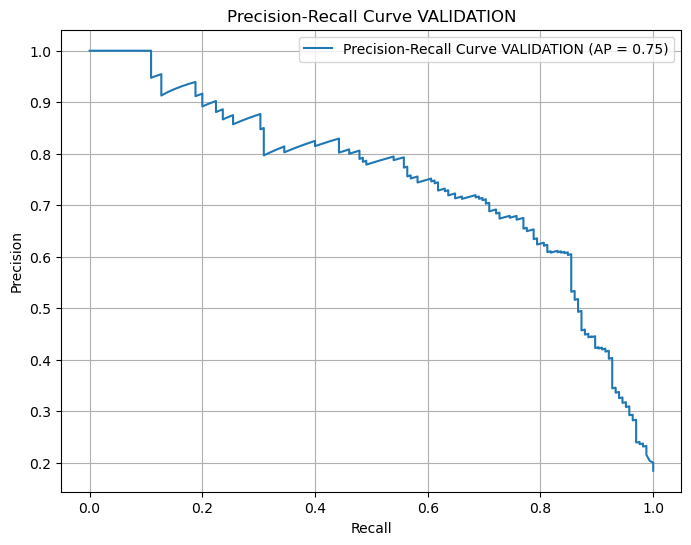

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Obtener las probabilidades de la clase positiva
y_scores = model_tuning.predict_proba(X_val)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_val, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve VALIDATION (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve VALIDATION')
plt.legend(loc='best')
plt.grid()
plt.show()

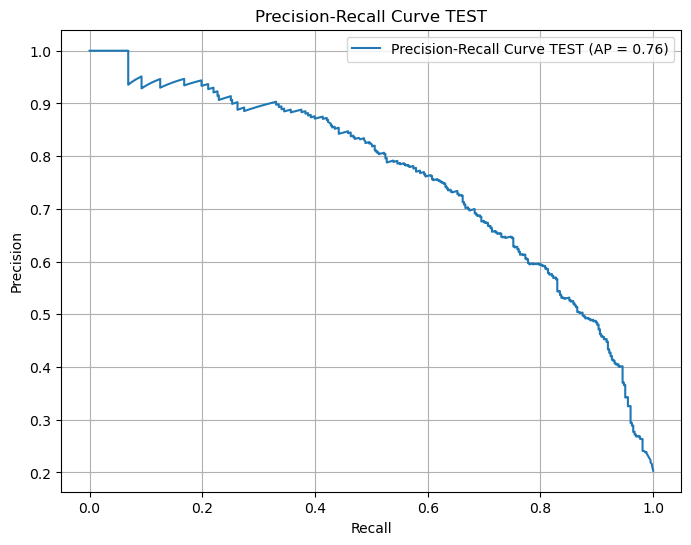

In [15]:
# Obtener las probabilidades de la clase positiva
y_scores = model_tuning.predict_proba(X_test)[:, 1]  # Asegúrate de usar el modelo que hayas entrenado

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calcular el promedio de la precisión
average_precision = average_precision_score(y_test, y_scores)

# Graficar la curva de precisión-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve TEST (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve TEST')
plt.legend(loc='best')
plt.grid()
plt.show()

In [16]:
pred_ptest = model_tuning.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_ptest[:, 1])
auc_test = metrics.auc(fpr, tpr)
f1_test = metrics.f1_score(y_test, y_pred_test)
prcson_test = metrics.precision_score(y_test, y_pred_test)

print(f"auc_test:{auc_test}")
print(f"f1_score_test:{f1_test}")
print(f"precision_test:{prcson_test}")
print(classification_report(y_test, y_pred_test))

conf_matrix_test = metrics.confusion_matrix(y_test, y_pred_test)
conf_matrix_test

auc_test:0.904258883784331
f1_score_test:0.6603260869565217
precision_test:0.7763578274760383
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1658
           1       0.78      0.57      0.66       423

    accuracy                           0.88      2081
   macro avg       0.84      0.77      0.79      2081
weighted avg       0.87      0.88      0.87      2081



array([[1588,   70],
       [ 180,  243]])

In [17]:
pred_pval = model_tuning.predict_proba(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_pval[:, 1])
auc_val = metrics.auc(fpr, tpr)
f1_val = metrics.f1_score(y_val, y_pred)
prcson_val = metrics.precision_score(y_val, y_pred)

print(f"auc_val:{auc_val}")
print(f"f1_score_val:{f1_val}")
print(f"precision_val:{prcson_val}")
print(classification_report(y_val, y_pred))

conf_matrix_val = metrics.confusion_matrix(y_val, y_pred)
conf_matrix_val

auc_val:0.909007659007659
f1_score_val:0.6530612244897959
precision_val:0.7441860465116279
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       728
           1       0.74      0.58      0.65       165

    accuracy                           0.89       893
   macro avg       0.83      0.77      0.79       893
weighted avg       0.88      0.89      0.88       893



array([[695,  33],
       [ 69,  96]])